ICFormer сравнивается с:

* RandomForest
* FeedForward Neural Network (FNN)
* 1D-Convolutional network (1D-Conv)
* DTW-CNN

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
import os
from tqdm.notebook import tqdm
import numpy as np
from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# MATR # 

Обработка файлов:   0%|          | 0/140 [00:00<?, ?it/s]


=== File: FastCharge_000000_CH19_structure.json (Barcode: el150800440551) ===
   cycle_index  discharge_capacity  charge_capacity  discharge_energy  \
0            0            1.934572         1.417352          6.116106   
1            1            1.045426         1.045648          3.173665   
2            2            1.048037         1.048442          3.176155   
3            3            1.048029         1.047885          3.175840   
4            4            1.049100         1.049186          3.182562   

   charge_energy  dc_internal_resistance  temperature_maximum  \
0       4.673017                0.029384            34.168961   
1       3.646161                0.017864            34.850071   
2       3.651186                0.017929            34.573605   
3       3.651785                0.018012            34.393002   
4       3.653328                0.017671            34.299545   

   temperature_average  temperature_minimum              date_time_iso  \
0            30.9

C:\Users\egork\AppData\Local\Temp\ipykernel_32488\1288858744.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


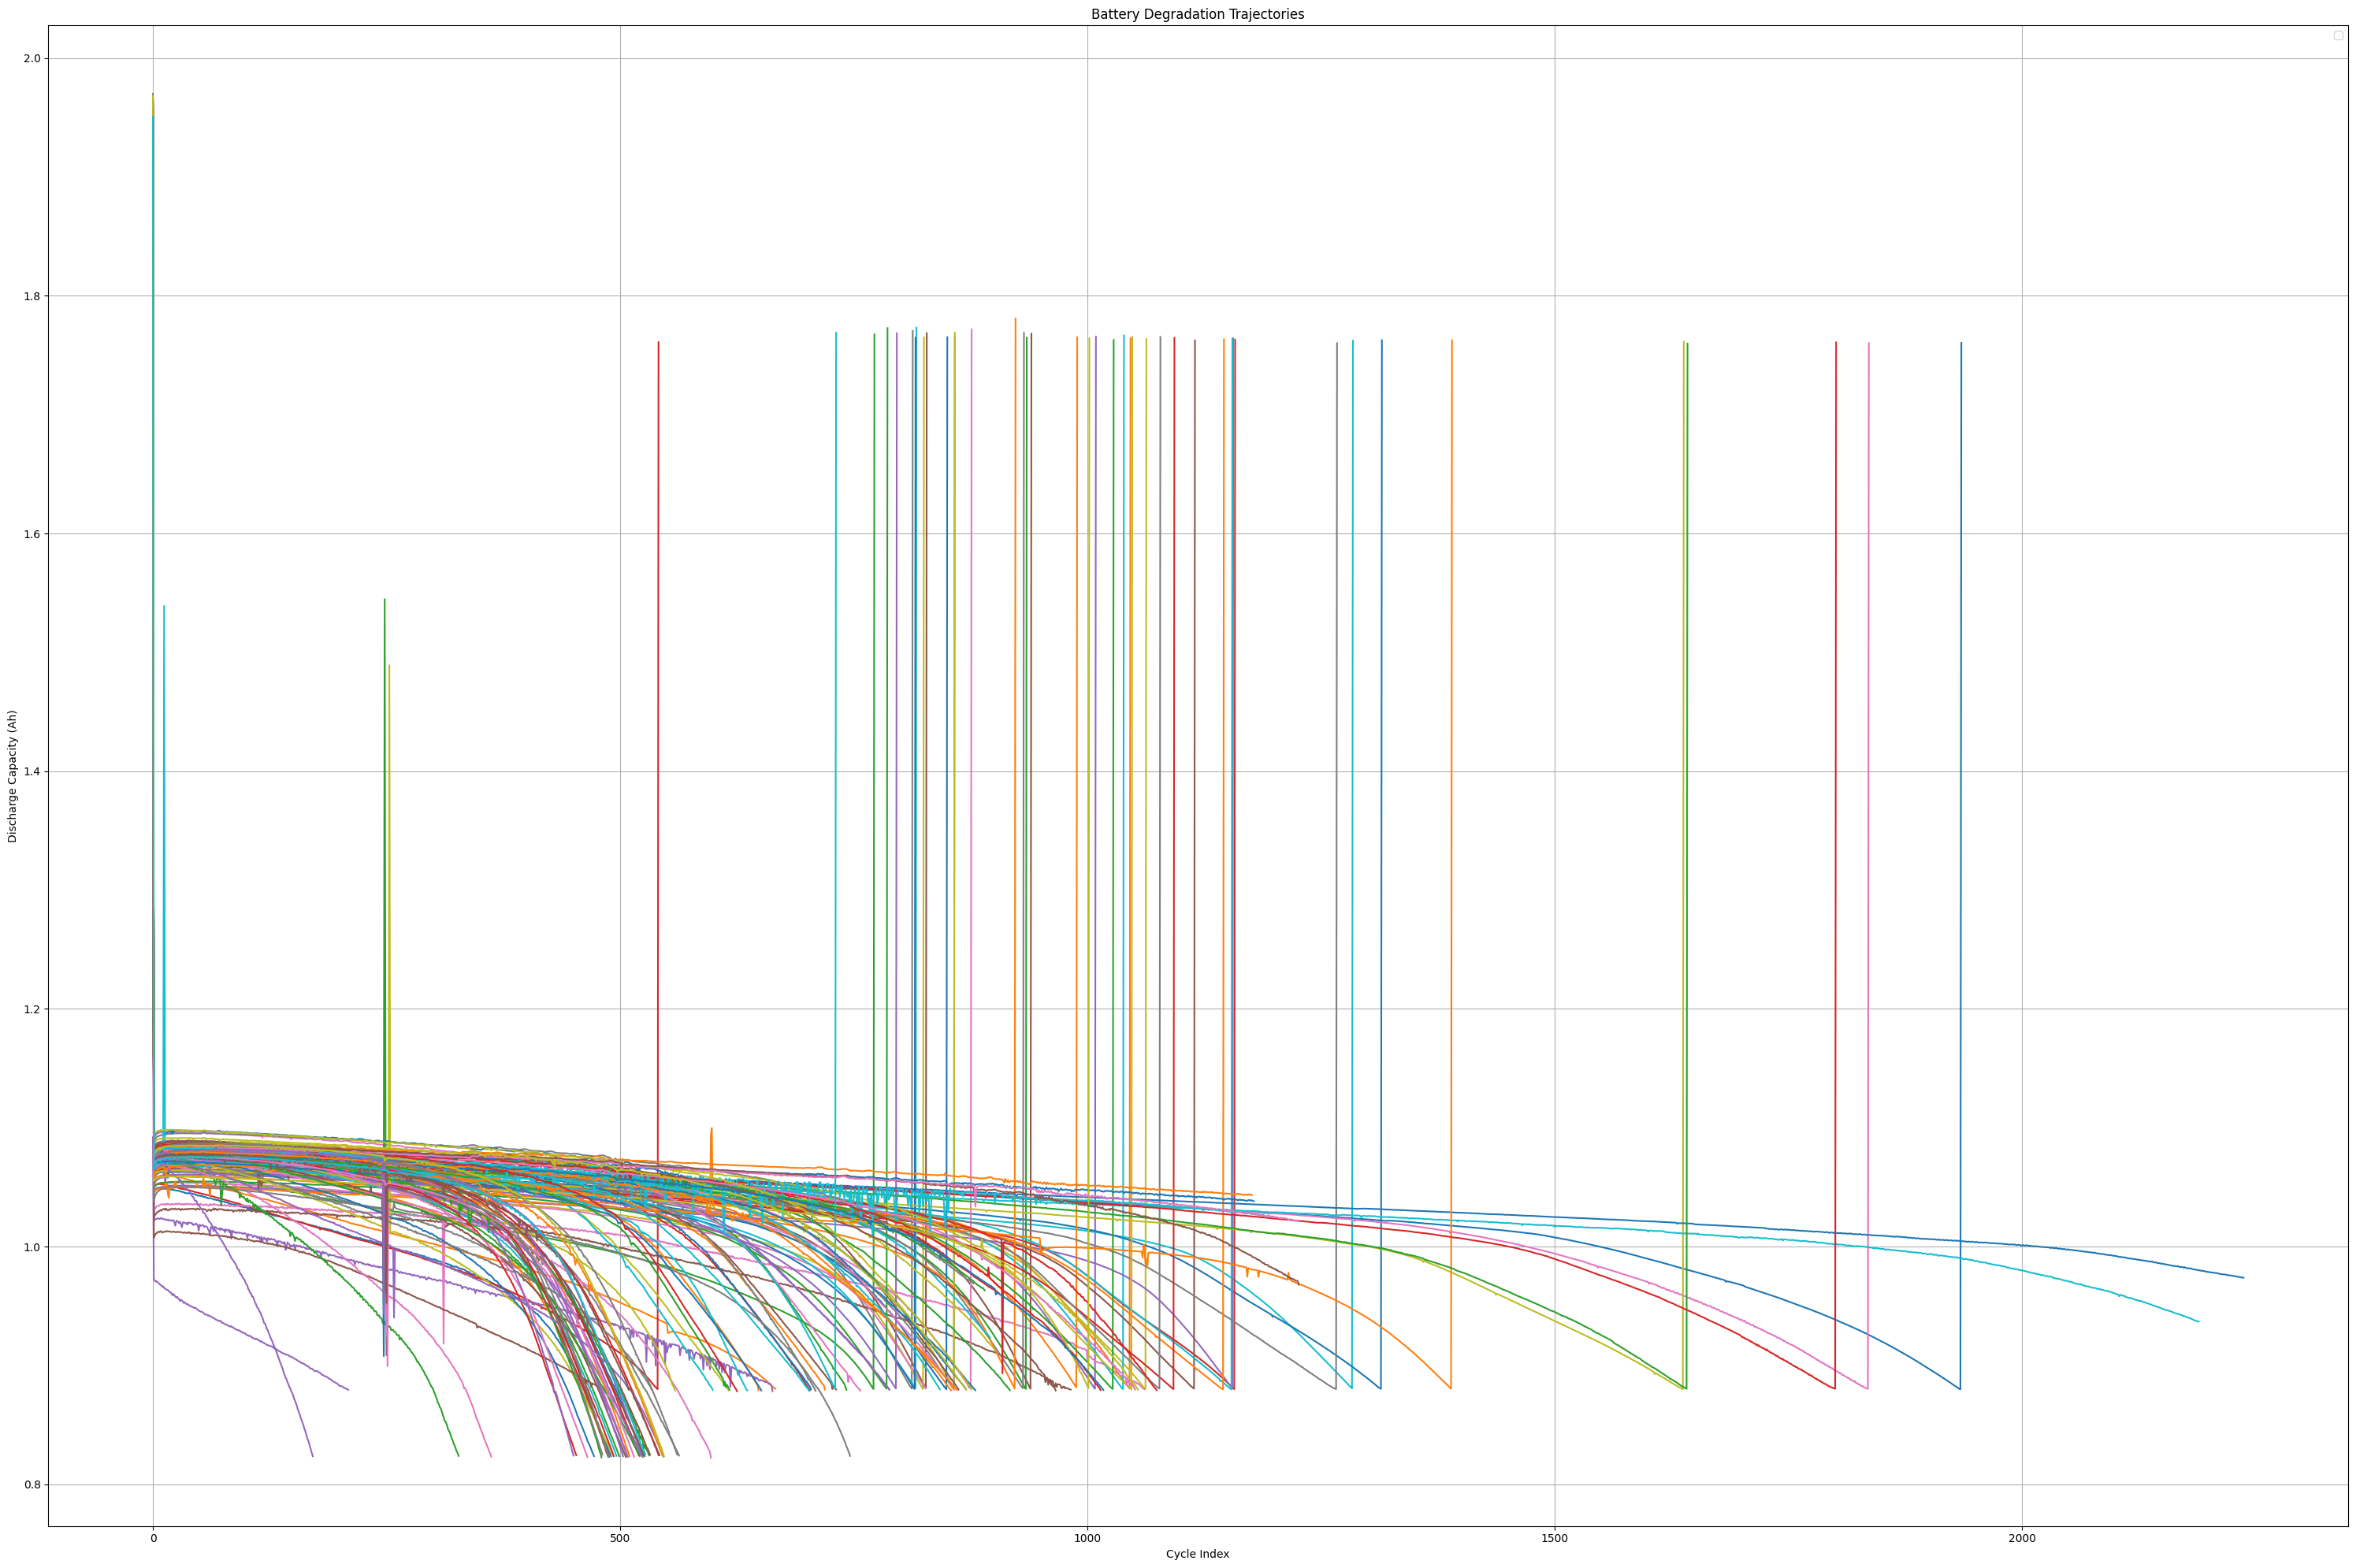

In [2]:
folder_path = r"C:\C\7 сем\Thesis\MATR"
matr = []

preview_files = 1

plt.figure(figsize=(30, 20))

json_files = [f for f in sorted(os.listdir(folder_path)) if f.endswith(".json")]

for idx, filename in enumerate(tqdm(json_files, desc="Обработка файлов")):
    file_path = os.path.join(folder_path, filename)
    with open(file_path, 'r') as f:
        data = json.load(f)

    barcode = data.get("barcode", os.path.splitext(filename)[0])
    summary = data.get("summary", {})

    df = pd.DataFrame(summary)
    df["barcode"] = barcode
    matr.append(df)

    plt.plot(df['cycle_index'], df['discharge_capacity'])

    if idx < preview_files:
        print(f"\n=== File: {filename} (Barcode: {barcode}) ===")
        print(df.head())

print(f"\nЗагружено {len(matr)} файлов.")

plt.xlabel("Cycle Index")
plt.ylabel("Discharge Capacity (Ah)")
plt.title("Battery Degradation Trajectories")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[171, 209, 327, 362, 450] [1801, 1836, 1935, 2189, 2237]
139 138
[171, 209, 327, 362, 450] [1801, 1836, 1935, 2189, 2237]


C:\Users\egork\AppData\Local\Temp\ipykernel_32488\938714569.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


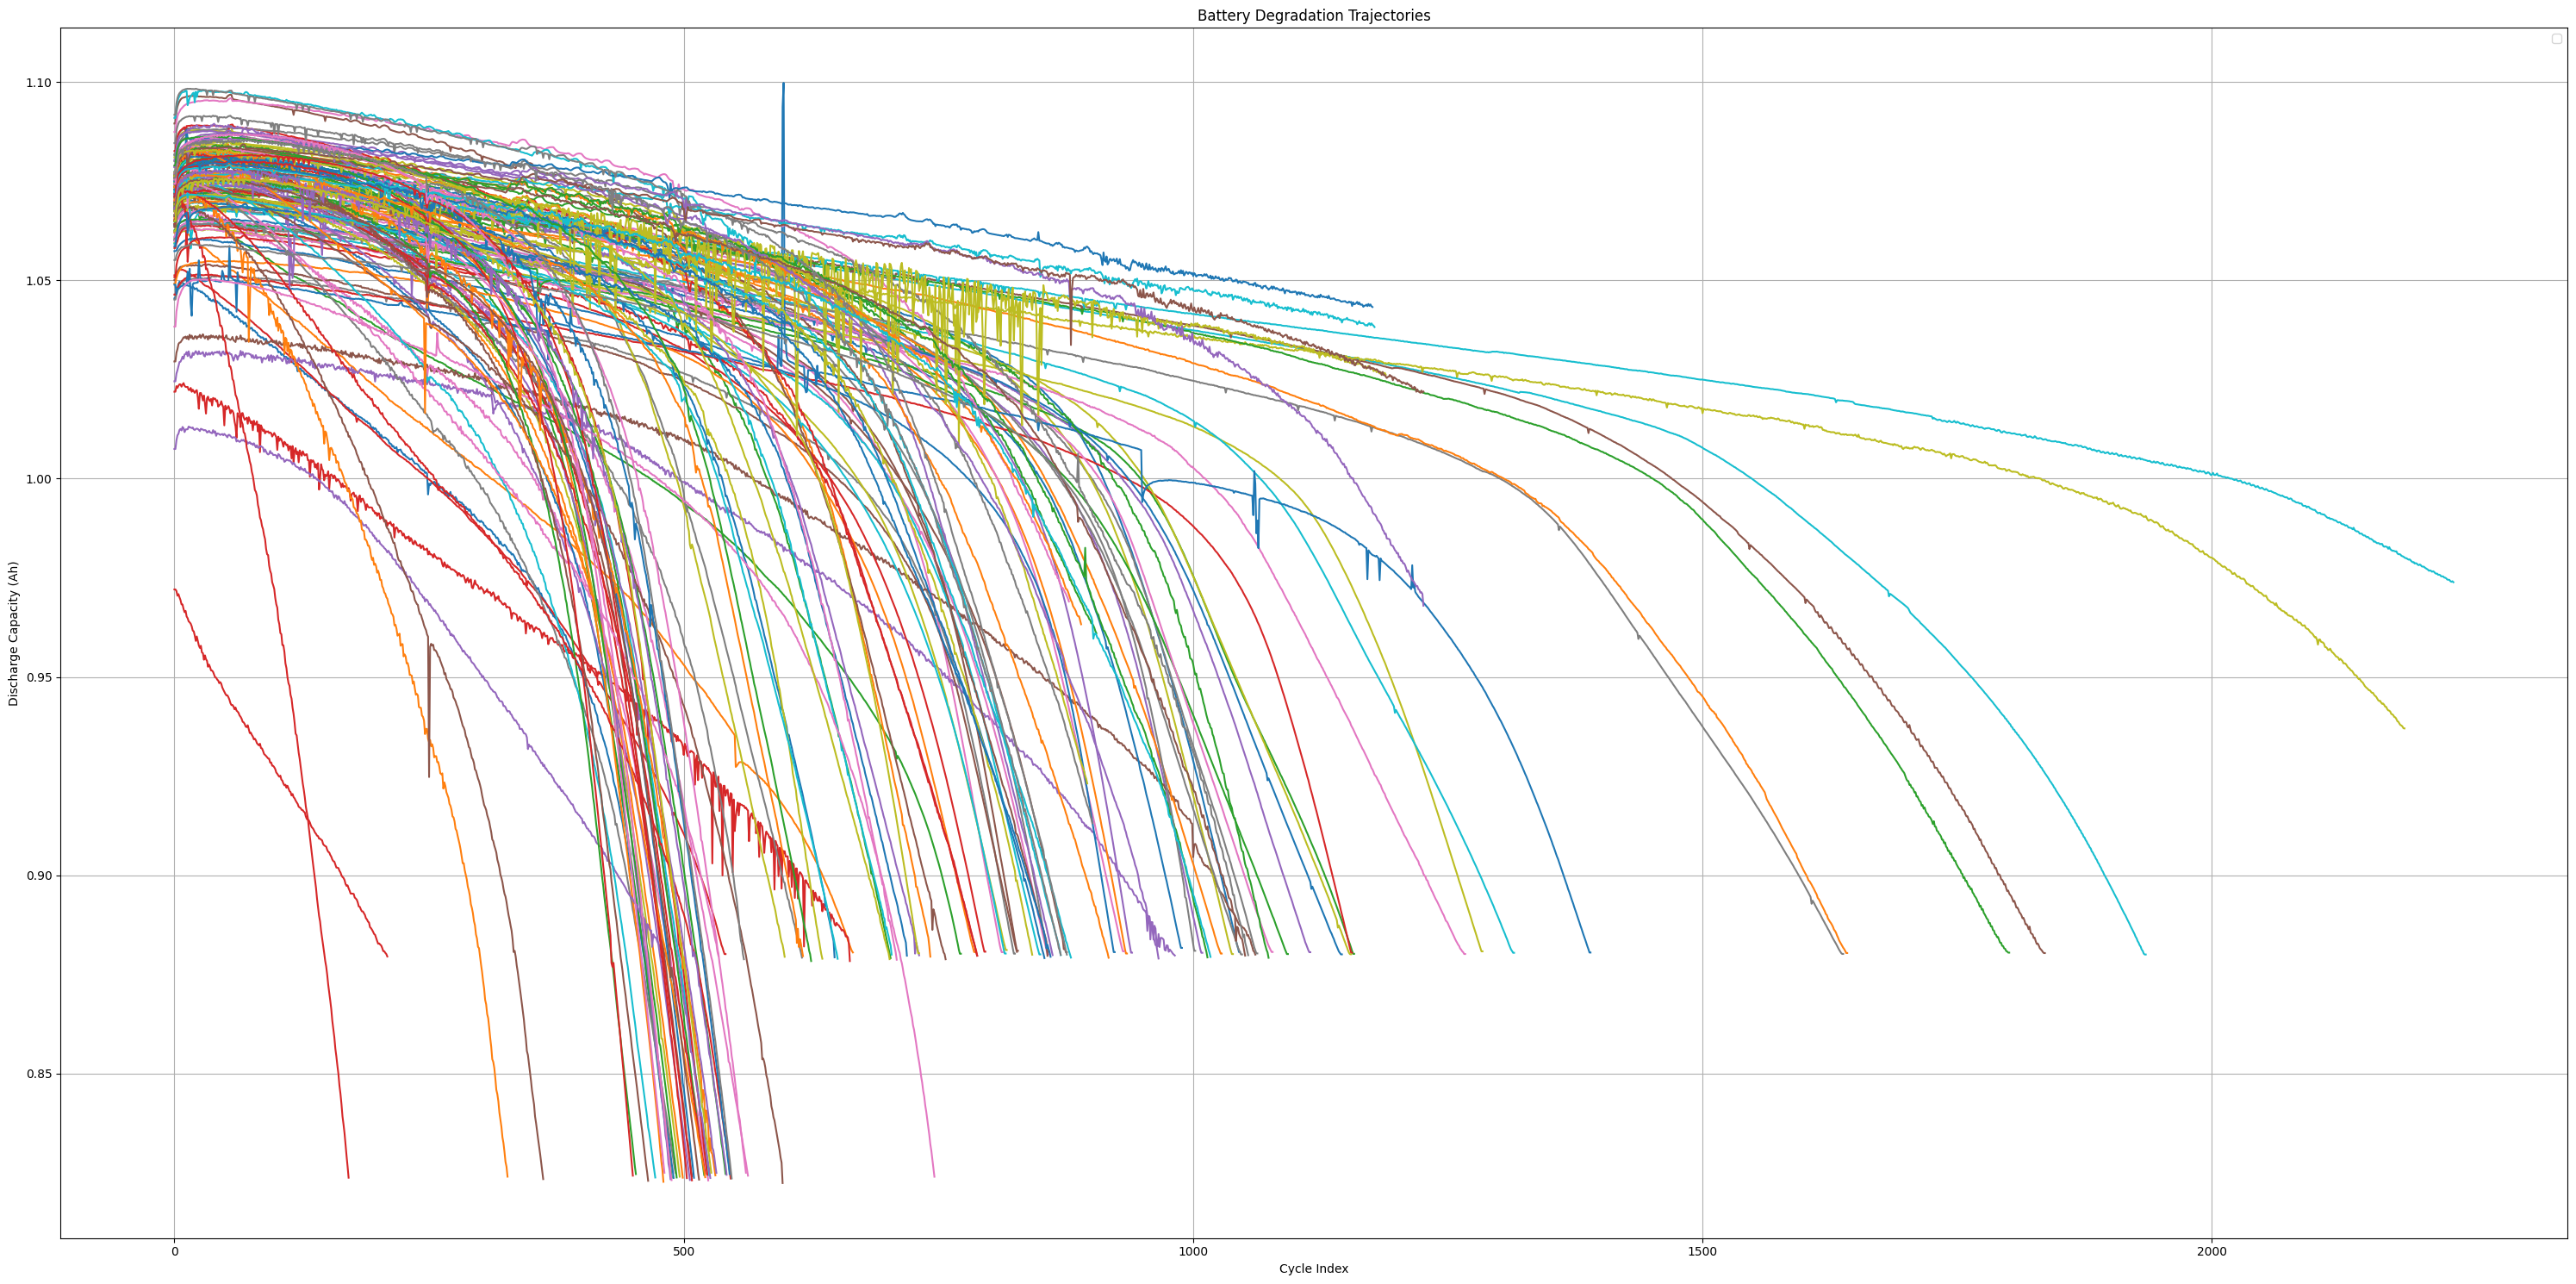

In [21]:
arr = []
for i in range(len(matr)):
    arr.append(matr[i]['cycle_index'].max())
arr = sorted(arr)
print(arr[:5], arr[-5:])

arr = []
l = len(matr) - 1
for i in range(l):
    if matr[i]['cycle_index'].max() == 0:
        del matr[i]
        l -= 1
    arr.append(matr[i]['cycle_index'].max())
arr = sorted(arr)
print(len(matr), len(arr))
print(arr[:5], arr[-5:])

def smoothing_series(series):
    series = series.copy()
    n = len(series)

    for i in range(n):
        if i == 0:
            if abs(series.iloc[0] - series.iloc[1]) > 0.05:
                series.iloc[0] = series.iloc[1]
        elif i == n - 1:
            if abs(series.iloc[-1] - series.iloc[-2]) > 0.05:
                series.iloc[-1] = series.iloc[-2]
        else:
            if (
                abs(series.iloc[i] - series.iloc[i - 1]) > 0.05 and
                abs(series.iloc[i] - series.iloc[i + 1]) > 0.05
            ):
                series.iloc[i] = (series.iloc[i - 1] + series.iloc[i + 1]) / 2
    return series

for i in range(len(matr)):
    matr[i]['discharge_capacity'] = smoothing_series(matr[i]['discharge_capacity'])

plt.figure(figsize=(30, 15))
for i in range(len(matr)):
    plt.plot(matr[i]['cycle_index'], matr[i]['discharge_capacity'])
plt.xlabel("Cycle Index")
plt.ylabel("Discharge Capacity (Ah)")
plt.title("Battery Degradation Trajectories")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Предобработка и подготовка данных ##

In [38]:
cmatr = matr.copy()
for i in range(len(cmatr)):
    cmatr[i] = cmatr[i].drop('cycle_index', axis=1)
    
    cmatr[i]['delta_capacity'] =  cmatr[i]['charge_capacity'] - cmatr[i]['discharge_capacity']
    cmatr[i]['charging_efficiency'] =  cmatr[i]['discharge_capacity'] / cmatr[i]['charge_capacity']
    cmatr[i]['delta_resistance'] =  cmatr[i]['dc_internal_resistance'].diff()
    cmatr[i]['delta_energy'] =  cmatr[i]['discharge_energy'].diff()
    cmatr[i]['delta_temperature'] =  cmatr[i]['temperature_average'].diff()
    
    cmatr[i]['theory_LLI'] = (cmatr[i]['discharge_capacity'].iloc[0] - cmatr[i]['discharge_capacity']) / cmatr[i]['discharge_capacity'].iloc[0]
    
    cmatr[i]['theory_LAMpe'] = (cmatr[i]['dc_internal_resistance'] - cmatr[i]['dc_internal_resistance'].iloc[0]) / cmatr[i]['discharge_capacity'].iloc[0] + cmatr[i]['theory_LLI']
    
    cmatr[i]['theory_LAMne'] = (cmatr[i]['charge_capacity'].iloc[0] - cmatr[i]['charge_capacity']) / cmatr[i]['charge_capacity'].iloc[0] - cmatr[i]['theory_LLI']

print(cmatr[0].head())

   discharge_capacity  charge_capacity  discharge_energy  charge_energy  \
0            1.045426         1.417352          6.116106       4.673017   
1            1.045426         1.045648          3.173665       3.646161   
2            1.048037         1.048442          3.176155       3.651186   
3            1.048029         1.047885          3.175840       3.651785   
4            1.049100         1.049186          3.182562       3.653328   

   dc_internal_resistance  temperature_maximum  temperature_average  \
0                0.029384            34.168961            30.977694   
1                0.017864            34.850071            32.641014   
2                0.017929            34.573605            32.274544   
3                0.018012            34.393002            32.078480   
4                0.017671            34.299545            32.473103   

   temperature_minimum              date_time_iso  energy_efficiency  ...  \
0            25.237902  2017-07-01T03:52:32+0

## Обучение моделей ##

In [43]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense

from tslearn.neural_network import TimeSeriesMLPClassifier, TimeSeriesMLPRegressor
from tslearn.preprocessing import TimeSeriesScalerMinMax


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: C:\Users\egork\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


## Тренировка моделей ##

## Генерация данных ##

# CALCE #

In [4]:
folder_path = r"C:\C\7 сем\Thesis\CALCE"

pkl_files = [f for f in sorted(os.listdir(folder_path)) if f.endswith(".pkl")]

all_cycle_data = []
meta_data_list = []

for filename in tqdm(pkl_files, desc="Обработка файлов"):
    file_path = os.path.join(folder_path, filename)
    try:
        obj = pd.read_pickle(file_path)

        if not isinstance(obj, dict):
            print(f"{filename} не является словарём.")
            continue

        # Извлекаем мета-данные (все поля, кроме 'cycle_data')
        meta_data = {k: v for k, v in obj.items() if k != 'cycle_data'}
        meta_data['source_file'] = filename

        # Добавим в список мета-данных
        meta_data_list.append(meta_data)

        # Обработка cycle_data
        if 'cycle_data' in obj and isinstance(obj['cycle_data'], list) and len(obj['cycle_data']) > 0:
            cycle_list = obj['cycle_data']
            first = cycle_list[0]

            # Преобразуем в датафрейм
            if hasattr(first, '__dict__'):
                df_cycles = pd.DataFrame([vars(c) for c in cycle_list])
            elif isinstance(first, dict):
                df_cycles = pd.DataFrame(cycle_list)
            else:
                print(f"{filename}: неизвестный формат cycle_data")
                continue

            # Добавим идентификаторы
            df_cycles['cell_id'] = obj.get('cell_id', 'unknown')
            df_cycles['source_file'] = filename
            all_cycle_data.append(df_cycles)
        else:
            print(f"{filename}: нет данных в 'cycle_data'.")

    except Exception as e:
        print(f"Ошибка при чтении {filename}: {e}")

# Собираем итоговые датафреймы
cycle_data_df = pd.concat(all_cycle_data, ignore_index=True)
meta_data_df = pd.DataFrame(meta_data_list)

# Вывод результатов
print(f"\nИтоговый размер cycle_data_df: {cycle_data_df.shape}")
print(f"Итоговый размер meta_data_df: {meta_data_df.shape}")

Обработка файлов:   0%|          | 0/13 [00:00<?, ?it/s]


Итоговый размер cycle_data_df: (14299, 10)
Итоговый размер meta_data_df: (13, 19)


In [5]:
# Объединение по 'cell_id' и 'source_file'
full_df = pd.merge(
    cycle_data_df,
    meta_data_df,
    on=['cell_id', 'source_file'],
    how='left',  # left join, чтобы сохранить все строки из cycle_data_df
    suffixes=('', '_meta')  # если вдруг есть совпадающие имена столбцов
)

print(f"\nИтоговый размер объединённого датафрейма: {full_df.shape}")
display(full_df.head(1))


Итоговый размер объединённого датафрейма: (14299, 27)


,cycle_number,current_in_A,voltage_in_V,charge_capacity_in_Ah,discharge_capacity_in_Ah,time_in_s,temperature_in_C,internal_resistance_in_ohm,cell_id,source_file,...,already_spent_cycles,max_voltage_limit_in_V,min_voltage_limit_in_V,max_current_limit_in_A,min_current_limit_in_A,reference,description,charge_protocol,discharge_protocol,SOC_interval
0,1,"[0.0, 0.0, 0.0, 0.0, 0.5500248074531555, 0.549...","[3.0353453159332275, 3.05300235748291, 3.06693...","[0.0, 0.0, 0.0, 0.0, 0.004585924537646664, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[50736.39126759555, 50766.409091594214, 50796....",None,None,CALCE_CS2_33,CALCE_CS2_33.pkl,...,0,4.2,2.7,None,None,None,None,[],[],"[0, 1]"


array([   1,    2,    3, ..., 1577, 1578, 1579], dtype=int64)

array([None], dtype=object)

array([None], dtype=object)

array(['CALCE_CS2_33', 'CALCE_CS2_34', 'CALCE_CS2_35', 'CALCE_CS2_36',
       'CALCE_CS2_37', 'CALCE_CS2_38', 'CALCE_CX2_16', 'CALCE_CX2_33',
       'CALCE_CX2_34', 'CALCE_CX2_35', 'CALCE_CX2_36', 'CALCE_CX2_37',
       'CALCE_CX2_38'], dtype=object)

array(['CALCE_CS2_33.pkl', 'CALCE_CS2_34.pkl', 'CALCE_CS2_35.pkl',
       'CALCE_CS2_36.pkl', 'CALCE_CS2_37.pkl', 'CALCE_CS2_38.pkl',
       'CALCE_CX2_16.pkl', 'CALCE_CX2_33.pkl', 'CALCE_CX2_34.pkl',
       'CALCE_CX2_35.pkl', 'CALCE_CX2_36.pkl', 'CALCE_CX2_37.pkl',
       'CALCE_CX2_38.pkl'], dtype=object)

array(['prismatic'], dtype=object)

array(['graphite'], dtype=object)

array(['LCO'], dtype=object)

array([None], dtype=object)

array([1.1 , 1.35])

array([1.])

array([1.])

array([0], dtype=int64)

array([4.2])

array([2.7])

array([None], dtype=object)

array([None], dtype=object)

array([None], dtype=object)

array([None], dtype=object)

Количество уникальных массивов: 1
Количество уникальных массивов: 1
Количество уникальных массивов: 1


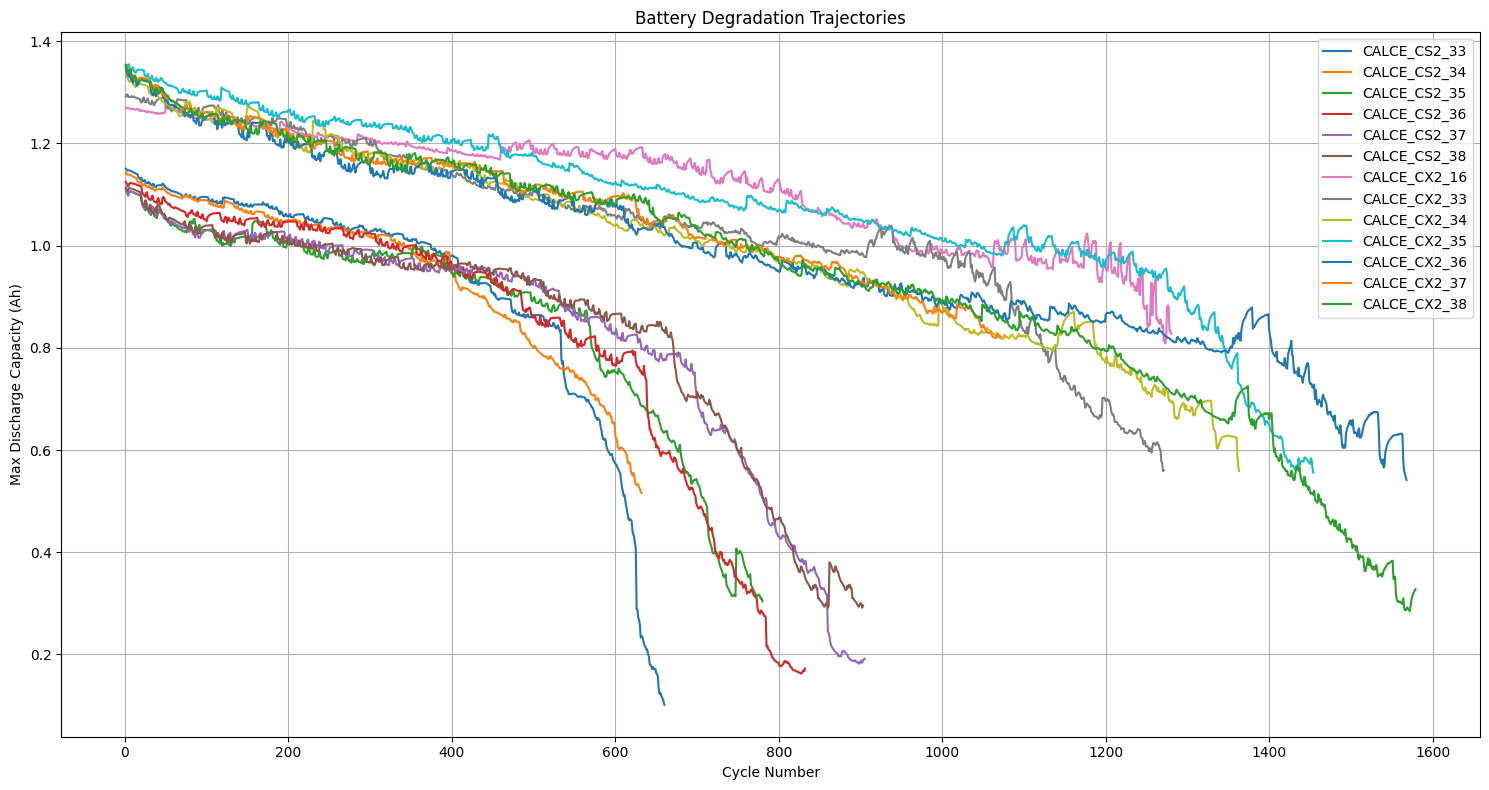

In [6]:
for col in full_df.columns:
    try:
        display(full_df[col].unique())
    except:
        continue

unique_arrays = full_df['charge_protocol'].apply(lambda x: tuple(x)).unique()
print(f"Количество уникальных массивов: {len(unique_arrays)}")

unique_arrays = full_df['discharge_protocol'].apply(lambda x: tuple(x)).unique()
print(f"Количество уникальных массивов: {len(unique_arrays)}")

unique_arrays = full_df['SOC_interval'].apply(lambda x: tuple(x)).unique()
print(f"Количество уникальных массивов: {len(unique_arrays)}")

plt.figure(figsize=(15, 8))

for cell_id, group in full_df.groupby('cell_id'):
    group_sorted = group.sort_values('cycle_number')
    
    # Преобразуем списки в числа (например, максимум)
    cycle_numbers = group_sorted['cycle_number']
    max_discharge_cap = group_sorted['discharge_capacity_in_Ah'].apply(
        lambda x: max(x) if isinstance(x, list) and len(x) > 0 else None
    )

    plt.plot(cycle_numbers, max_discharge_cap, label=cell_id)

plt.xlabel("Cycle Number")
plt.ylabel("Max Discharge Capacity (Ah)")
plt.title("Battery Degradation Trajectories")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# HNEI #

In [1]:
import os, gc
import numpy as np, pandas as pd
from scipy.io import loadmat, whosmat

FOLDER = r"C:\C\7 сем\Thesis\2h8cpszy26-1"
DUTY_FILE = os.path.join(FOLDER, "Gr-NCA_Co33_cha_124652duty.mat")
PART_FILES = [
    os.path.join(FOLDER, "Gr-NCA_Co33_cha_1.mat"),
    os.path.join(FOLDER, "Gr-NCA_Co33_cha_2.mat"),
    os.path.join(FOLDER, "Gr-NCA_Co33_cha_3.mat"),
]

# 1) загружайте небольшие матрицы в память
print("Loading small matrices from duty file...")
wanted = ['LLIeq','LAMPEeq','LAMNEeq','QL','Vi','cyc','key']
mat = loadmat(DUTY_FILE, variable_names=wanted)
dfs = {}
for k in ['LLIeq','LAMPEeq','LAMNEeq','QL','Vi']:
    if k in mat:
        arr = np.array(mat[k])  # shape (n_samples, n_checkpoints)
        dfs[k] = pd.DataFrame(arr)
        print(f"  {k} shape {arr.shape}")
# циклические контрольные точки -> использовать в качестве имен столбцов
if 'cyc' in mat:
    cyc = np.array(mat['cyc']).squeeze()
    col_names = [f"cycle_{int(c)}" for c in cyc]
    for k in dfs:
        dfs[k].columns = col_names
    print("  cycle checkpoints:", col_names)

# 2) загрузите pathinfo и Qnorm/Vnorm из части 1 (небольшой)
print("\nLoading pathinfo and Qnorm/Vnorm from part1...")
p1 = loadmat(PART_FILES[0], variable_names=['pathinfo','pathinfo_index','Qnorm','Vnorm'])
pathinfo = np.array(p1['pathinfo'])
df_pathinfo = pd.DataFrame(pathinfo)
# адаптировать имена столбцов, если формат совпадает (общий формат: [global_col, sample_id, cycle_checkpoint, extra])
# безопасное преобразование pathinfo -> int там, где это корректно
df_pathinfo = pd.DataFrame(pathinfo)
# возьмём только первые 4 колонки как раньше
if df_pathinfo.shape[1] >= 4:
    df_pathinfo = df_pathinfo.iloc[:, :4].copy()
    df_pathinfo.columns = ['col_global','sample_id','cycle_checkpoint','extra']

# быстрый просмотр распределения (пара примеров)
print("pathinfo sample (first rows):")
print(df_pathinfo.head(8))

# функция: попытка привести столбец к целым, оставляя NaN там, где не подходит
def safe_to_int_series(s, tol=1e-6):
    arr = pd.to_numeric(s, errors='coerce').to_numpy(dtype=float)
    # отметим значения близкие к целым
    is_close = np.isfinite(arr) & (np.abs(arr - np.round(arr)) <= tol)
    out = np.full(arr.shape, pd.NA, dtype="object")
    out[is_close] = np.round(arr[is_close]).astype(np.int64)
    # вернуть в виде Series с Int64 nullable
    return pd.Series(out).astype("Int64")

# применяем к трём ключевым столбцам
for c in ['col_global','sample_id','cycle_checkpoint']:
    df_pathinfo[c+'_raw'] = df_pathinfo[c]              # сохраним оригинал на случай
    df_pathinfo[c] = safe_to_int_series(df_pathinfo[c], tol=1e-6)

print("\nAfter safe cast, value counts (sample):")
print("col_global:", df_pathinfo['col_global'].value_counts(dropna=False).head())
print("sample_id:", df_pathinfo['sample_id'].value_counts(dropna=False).head())
print("cycle_checkpoint unique:", df_pathinfo['cycle_checkpoint'].dropna().unique()[:20])

# если столбцы оказались нецелыми и много NaN, можно рассмотреть округление без проверки:
# df_pathinfo['sample_id'] = pd.to_numeric(df_pathinfo['sample_id_raw'], errors='coerce').round().astype('Int64')

# Qnorm/Vnorm grids
Qnorm = np.array(p1.get('Qnorm')).squeeze() if 'Qnorm' in p1 else None
Vnorm = np.array(p1.get('Vnorm')).squeeze() if 'Vnorm' in p1 else None
print("  Qnorm len:", None if Qnorm is None else Qnorm.shape)
print("  Vnorm len:", None if Vnorm is None else Vnorm.shape)

# 3) вычислите количество столбцов детали и глобальные границы
part_counts = []
for pf in PART_FILES:
    info = whosmat(pf)
    # Найти название и  shape volt_part
    vp = None
    for name, shape, dtype in info:
        if name.startswith('volt_part'):
            vp = (name, shape)
            break
    if vp is None:
        raise RuntimeError(f"No volt_part in {pf}")
    part_counts.append(vp[1][1])  # число столбцов
print("\nPart column counts:", part_counts)
boundaries = np.cumsum([0] + part_counts)  # границы глобальных индексов
print("Boundaries:", boundaries.tolist())

# helper: map sample+checkpoint -> global cols
def get_global_cols_for_sample_cycle(sample_id:int, cycle_checkpoint:int):
    rows = df_pathinfo[
        (df_pathinfo['sample_id'] == int(sample_id)) &
        (df_pathinfo['cycle_checkpoint'] == int(cycle_checkpoint))
    ]
    if rows.empty:
        return []
    cols = rows['col_global'].dropna().astype(int).tolist()
    cols.sort()
    return cols

# helper: read selected global columns into memory (attempt per-part loading)
def read_global_columns_in_memory(global_cols):
    """
    Returns dict {global_col: column_array} for columns successfully read.
    Attempts to load each relevant part file one by one to limit peak memory.
    """
    global_cols = sorted(set(int(c) for c in global_cols))
    if not global_cols:
        return {}
    results = {}
    # map global col -> (part_idx, local_idx)
    mapping = {}
    for g in global_cols:
        part_idx = np.searchsorted(boundaries, g, side='right') - 1
        local_idx = g - boundaries[part_idx]
        mapping.setdefault(part_idx, []).append((g, local_idx))
    # обработайте каждую часть: загрузите эту часть, извлеките локальные значения cols, затем удалите
    for part_idx, items in mapping.items():
        pf = PART_FILES[part_idx]
        # find variable name
        info = whosmat(pf)
        varname = None
        for name, shape, dtype in info:
            if name.startswith('volt_part'):
                varname = name; break
        print(f"Loading variable {varname} from {os.path.basename(pf)} ...")
        try:
            mat = loadmat(pf, variable_names=[varname])
            arr = np.array(mat[varname])  # may be large -> catch MemoryError
            # arr shape expected (nrows, ncols)
            for g, local_idx in items:
                try:
                    col = arr[:, local_idx].astype(float).squeeze()
                    results[g] = col
                    print(f"  extracted global {g} (local {local_idx}) shape {col.shape}")
                except IndexError:
                    results[g] = None
                    print(f"  local index {local_idx} out of bounds for {varname}")
            # освобождение памяти
            del mat, arr
            gc.collect()
        except MemoryError:
            print("MemoryError: не удалось загрузить весь массив volt_part из-за памяти.")
            # пометить неудачные глобальные вызовы как отсутствующие
            for g, _ in items:
                results[g] = None
            return results
        except Exception as e:
            print("Ошибка при чтении", pf, e)
            for g, _ in items:
                results[g] = None
            return results
    return results

from scipy.signal import savgol_filter
def compute_dQdV_from_Vcol(V_col, Q_grid, N=128, sg_win=11, sg_poly=3):
    V = np.array(V_col).squeeze()
    Q = np.array(Q_grid).squeeze()
    if V.shape[0] != Q.shape[0]:
        m = min(V.shape[0], Q.shape[0])
        V = V[:m]; Q = Q[:m]
    # сортировка по V для интерполяции
    idx = np.argsort(V)
    Vs = V[idx]; Qs = Q[idx]
    uniq_v, ind = np.unique(Vs, return_index=True)
    Qu = Qs[ind]
    Vg = np.linspace(np.min(Vs), np.max(Vs), N)
    Q_interp = np.interp(Vg, uniq_v, Qu)
    # сглаживание и дифференциация
    if sg_win >= len(Q_interp):
        sg_win = len(Q_interp)-1 if (len(Q_interp)-1)%2==1 else len(Q_interp)-2
        if sg_win < 3: sg_win = 3
    try:
        Qs_s = savgol_filter(Q_interp, sg_win, sg_poly)
    except Exception:
        Qs_s = Q_interp
    dQdV = np.gradient(Qs_s, Vg)
    # нормализация
    dQdV = (dQdV - np.nanmean(dQdV)) / (np.nanstd(dQdV) + 1e-12)
    return Vg, dQdV

# ---------- Пример: попробуйте извлечь образец и контрольную точку (первую найденную) ----------
# выберите первый sample_id и контрольную точку, которая существует для него
sample_candidates = df_pathinfo['sample_id'].dropna().unique()
if len(sample_candidates)==0:
    raise RuntimeError("pathinfo не содержит информации о sample_id")
sample_id = int(sample_candidates[0])

available_checkpoints = [int(c.split('_')[1]) for c in dfs['LLIeq'].columns]
checkpoint = available_checkpoints[min(2, len(available_checkpoints)-1)]
print(f"\nExample: sample_id={sample_id}, checkpoint={checkpoint}")
# выберите контрольную точку, присутствующую в столбцах dfs (выберите вторую доступную, чтобы избежать cycle_0)
global_cols = get_global_cols_for_sample_cycle(sample_id, checkpoint)
print("Found global columns count:", len(global_cols))
if not global_cols:
    print("Нет глобальных колонок для запрошенного sample/checkpoint. Выберите другой sample или checkpoint.")
else:
    # попробуйте запомнить первые несколько столбцов
    cols_to_read = global_cols[:4]  # ограничим чтение в демо
    volt_cols = read_global_columns_in_memory(cols_to_read)
    # найти первое успешно прочитанное
    first_read = None
    for g, col in volt_cols.items():
        if col is not None:
            first_read = (g, col); break
    if first_read:
        g, col = first_read
        Vg, dQdV = compute_dQdV_from_Vcol(col, Qnorm, N=128)
        print(f"Computed dQ/dV for global col {g}: dQdV length {len(dQdV)}")
        # сохранить в памяти переменные для дальнейшей работы:
        example = {
            'sample_id': sample_id,
            'checkpoint': checkpoint,
            'global_col': g,
            'V_col': col,
            'Vg': Vg,
            'dQdV': dQdV
        }
    else:
        print("Не удалось прочитать ни одной колонки из выбранных частей (памяти не хватило или индексы неверны).")

    # Возвращает объекты в памяти: dfs, df_pathinfo, пример (если есть)
print("\nГотово. Объекты в памяти: dfs keys:", list(dfs.keys()), ", pathinfo rows:", len(df_pathinfo))
if 'example' in locals():
    print("Пример dQ/dV готов для дальнейшей обработки. Переменная: example")
else:
    print("Пример dQ/dV не получен.")


Loading small matrices from duty file...
  LLIeq shape (124652, 35)
  LAMPEeq shape (124652, 35)
  LAMNEeq shape (124652, 35)
  QL shape (124652, 35)
  Vi shape (124652, 35)
  cycle checkpoints: ['cycle_0', 'cycle_10', 'cycle_20', 'cycle_30', 'cycle_40', 'cycle_50', 'cycle_60', 'cycle_70', 'cycle_80', 'cycle_90', 'cycle_100', 'cycle_110', 'cycle_120', 'cycle_130', 'cycle_140', 'cycle_150', 'cycle_160', 'cycle_170', 'cycle_180', 'cycle_190', 'cycle_200', 'cycle_400', 'cycle_600', 'cycle_800', 'cycle_1000', 'cycle_1200', 'cycle_1400', 'cycle_1600', 'cycle_1800', 'cycle_2000', 'cycle_2200', 'cycle_2400', 'cycle_2600', 'cycle_2800', 'cycle_3000']

Loading pathinfo and Qnorm/Vnorm from part1...
pathinfo sample (first rows):
   col_global  sample_id  cycle_checkpoint     extra
0         0.0        0.0             0.000  0.000000
1         0.0        0.0             0.085  0.000000
2         0.0        0.0             0.170  0.000000
3         0.0        0.0             0.255  0.000000
4     

In [2]:
import numpy as np, pandas as pd
import inspect

def show_df(name, df):
    print(f"\n-- {name} (DataFrame) shape={getattr(df,'shape',None)} --")
    with pd.option_context('display.max_rows',5,'display.max_columns',10,'display.width',200):
        try:
            print(df.head(5))
        except Exception as e:
            print("  <error showing head>", e)

def show_array(name, arr):
    try:
        a = np.array(arr)
        print(f"\n-- {name} (ndarray) dtype={a.dtype} shape={a.shape} --")
        # показать небольшой образец
        if a.size:
            flat = a.ravel()[:10]
            print(flat)
        else:
            print("  <empty>")
    except Exception as e:
        print(f"\n-- {name} (error inspecting): {e}")

def show_dict(name, d):
    print(f"\n-- {name} (dict) keys={list(d.keys())[:20]} (total {len(d)}) --")
    for k in list(d.keys())[:10]:
        v = d[k]
        t = type(v)
        print(f"  key={k} type={t}", end="")
        if isinstance(v, pd.DataFrame):
            print(f" -> DataFrame shape={v.shape}")
            print(v.head(2))
        elif isinstance(v, (list, tuple)):
            print(f" -> {t} len={len(v)}")
        elif isinstance(v, np.ndarray):
            print(f" -> ndarray shape={v.shape} sample={v.ravel()[:5]}")
        else:
            try:
                print(" -> repr:", repr(v)[:120])
            except Exception:
                print()

# Имена, которые мы ожидаем от загрузчика
names = [
    'dfs', 'df_pathinfo', 'Qnorm', 'Vnorm',
    'part_counts', 'boundaries', 'sample_candidates',
    'sample_id','checkpoint','global_cols','volt_cols','example'
]

g = globals()
for name in names:
    if name in g:
        obj = g[name]
        if isinstance(obj, pd.DataFrame):
            show_df(name, obj)
        elif isinstance(obj, dict):
            show_dict(name, obj)
        elif isinstance(obj, np.ndarray):
            show_array(name, obj)
        elif isinstance(obj, list):
            print(f"\n-- {name} (list) len={len(obj)} sample types: ", end="")
            if obj:
                print(type(obj[0]))
            else:
                print("empty")
            print("  sample items:", obj[:5])
        else:
            # простые объекты или скаляры
            print(f"\n-- {name} ({type(obj).__name__}) repr:")
            try:
                print(repr(obj)[:400])
            except Exception as e:
                print("  <error repr>", e)

# дополнительно проверьте содержимое dfs, если оно присутствует
if 'dfs' in g and isinstance(g['dfs'], dict):
    for k, df in g['dfs'].items():
        if isinstance(df, pd.DataFrame):
            print(f"\n== dfs['{k}'] shape={df.shape} columns (first 10): {list(df.columns)[:10]}")
            print(df.iloc[:3,:10])

print("\n--- END OF INSPECTION ---")



-- dfs (dict) keys=['LLIeq', 'LAMPEeq', 'LAMNEeq', 'QL', 'Vi'] (total 5) --
  key=LLIeq type=<class 'pandas.core.frame.DataFrame'> -> DataFrame shape=(124652, 35)
   cycle_0  cycle_10  cycle_20  cycle_30  cycle_40  cycle_50  cycle_60  \
0      0.0      0.07      0.14      0.21      0.28      0.35      0.42   
1      0.0      0.07      0.14      0.21      0.28      0.35      0.42   

   cycle_70  cycle_80  cycle_90  ...  cycle_1200  cycle_1400  cycle_1600  \
0      0.49      0.56      0.63  ...      8.4006      9.8008      11.201   
1      0.49      0.56      0.63  ...      8.4006      9.8008      11.201   

   cycle_1800  cycle_2000  cycle_2200  cycle_2400  cycle_2600  cycle_2800  \
0   12.601201   14.001401   15.401601   16.801802   18.202002   19.602203   
1   12.601201   14.001401   15.401601   16.801802   18.202002   19.602203   

   cycle_3000  
0   21.002403  
1   21.002403  

[2 rows x 35 columns]
  key=LAMPEeq type=<class 'pandas.core.frame.DataFrame'> -> DataFrame shape=(1246

* dfs - содержит информацию о деградации [LLI, LAMPE, LAMNE, QL, Vi]. Каждая строка соответствует одной истории деградации (в реальном наборе это была бы одна ячейка)
* df_pathinfo - таблица сопоставлений глллобальных индексов столбца (volt_part1 | 2 | 3) и метаданными (sample_id и тд)
* part_counts и boundaries - помогают перевести col_global в одну из трёх частей (volt_part1 | 2 | 3) и локальный индекс.
* Qnorm и Vnorm - сетки ёмкости и напряжений соответственно. Как линейнки, по которым размечены данные.

## Обучение моделей ##

Используем 500 образцов для анализа (макс. 500).
Обрезание не требуется. Максимальное число циклов в данных: 35

Начинаем детальный фиттинг DDP/BW/DBW для 500 траекторий.


DDP/BW/DBW Analysis:   0%|          | 0/500 [00:00<?, ?it/s]

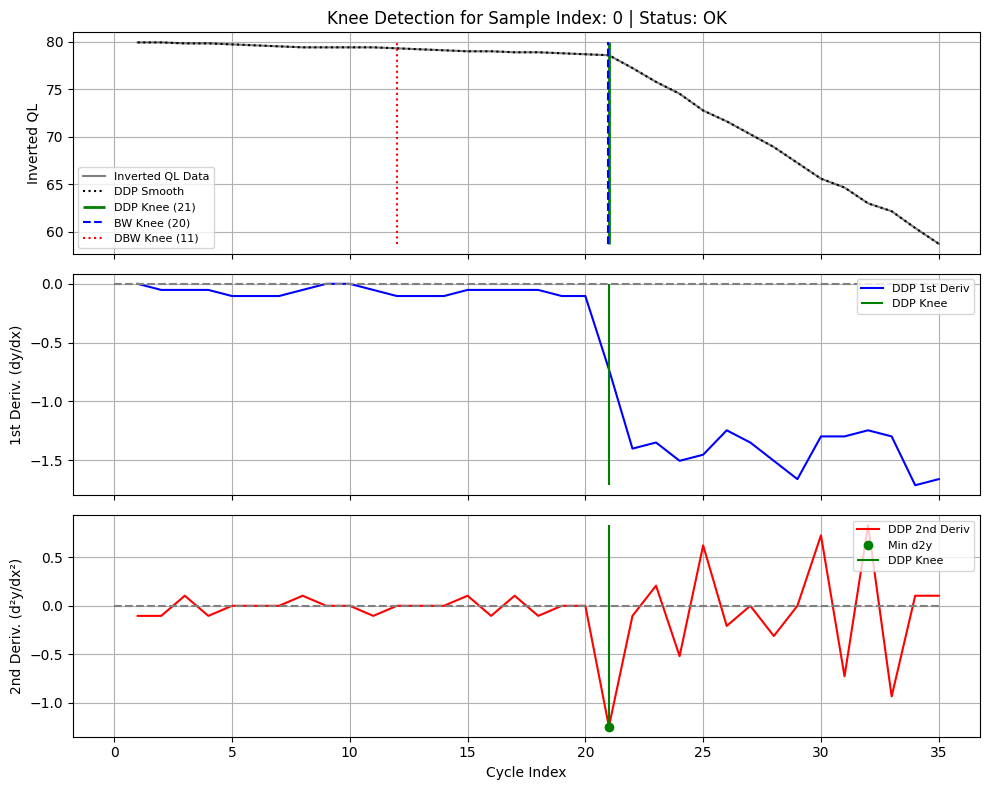

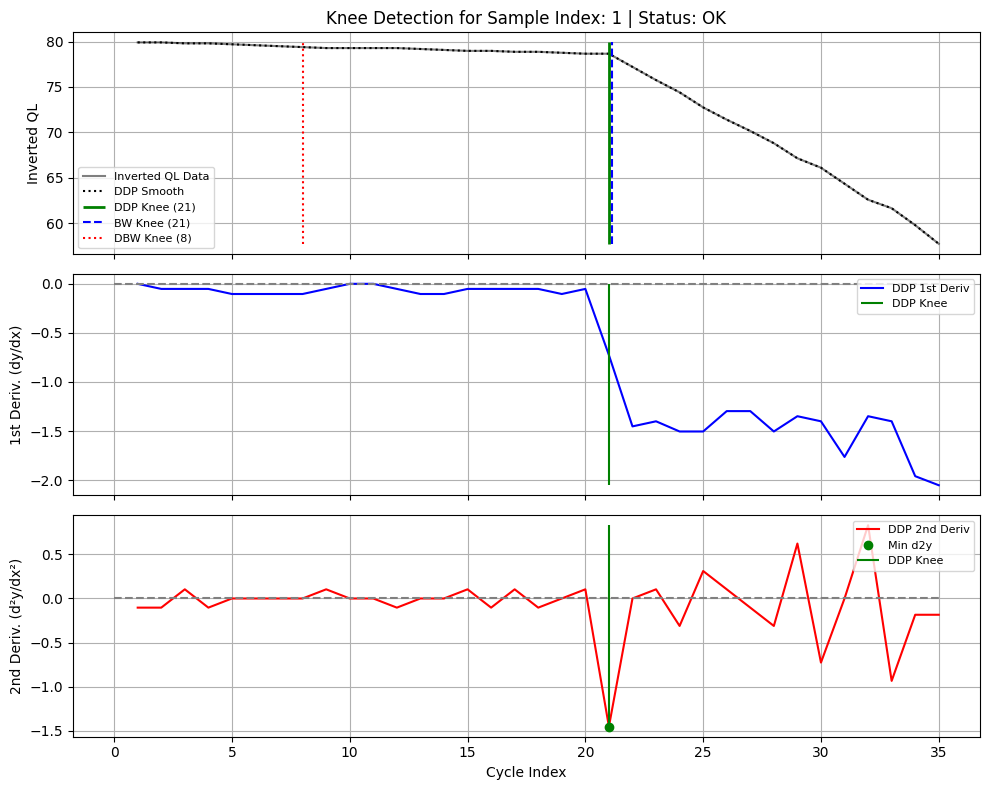


Начинаем извлечение признаков и расчет целей для ML...


Feature Engineering:   0%|          | 0/500 [00:00<?, ?it/s]

Обработка признаков завершена. Валидных образцов для ML: 229

НАЧАЛО РЕГРЕССИОННЫХ ЗАДАЧ (RandomForestRegressor)

--- Задача: Прогнозирование LLIeq ---
Root Mean Squared Error (RMSE): 5.7012
Топ-3 важных признака:
Q_std               0.379774
Intercept_Linear    0.271458
Q_mean              0.121639
dtype: float64

--- Задача: Прогнозирование LAMPEeq ---
Root Mean Squared Error (RMSE): 10.5403
Топ-3 важных признака:
DDP_2nd_Std    0.295855
Q_range        0.224085
Q_final        0.155754
dtype: float64

--- Задача: Прогнозирование LAMNEeq ---
Root Mean Squared Error (RMSE): 14.4020
Топ-3 важных признака:
DDP_2nd_Min         0.351258
DDP_2nd_Std         0.159345
Intercept_Linear    0.131254
dtype: float64

НАЧАЛО КЛАССИФИКАЦИОННЫХ ЗАДАЧ (RandomForestClassifier)

--- Задача: Классификация колена knee_BW (Рано/Поздно) ---
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        46

    accuracy        

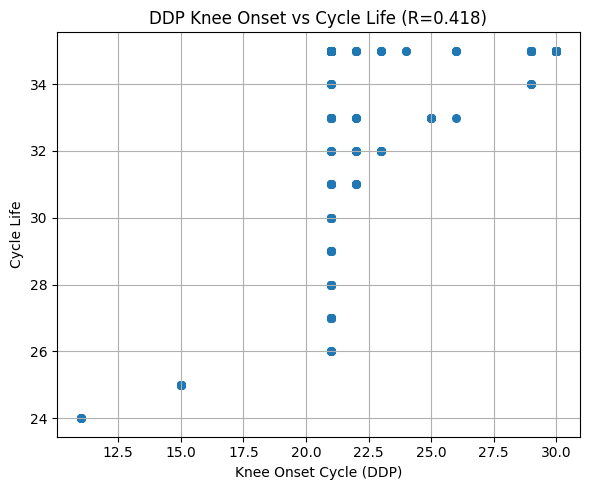


--- 2. Общее Резюме Обучения Моделей (Время: 0.91 сек) ---
Использовано признаков (X): 9
Количество образцов для обучения: 229
Пороговая классификация колена: < 50% Cycle Life (1: Рано, 0: Поздно)
| Task     | Metric   |   Value |
|:---------|:---------|--------:|
| LLIeq    | RMSE     |  5.7012 |
| LAMPEeq  | RMSE     | 10.5403 |
| LAMNEeq  | RMSE     | 14.402  |
| knee_BW  | Accuracy |  1      |
| knee_DBW | Accuracy |  0.913  |
| knee_DDP | Accuracy |  1      |


In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import warnings
import time
from tqdm.notebook import tqdm

# Импорт ML-библиотек
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

# Отключение предупреждений для чистой работы curve_fit
warnings.filterwarnings("ignore")

# --- ЗАГЛУШКА ДЛЯ DFS: Если вы запускаете код без импорта, он выдаст ошибку ---
# УБЕДИТЕСЬ, ЧТО СЛОВАРЬ 'dfs' ЗАГРУЖЕН И СОДЕРЖИТ ДАННЫЕ ВАШЕЙ ДЕГРАДАЦИИ
try:
    dfs
except NameError:
    # Пример структуры (вам нужно заменить это на реальную загрузку данных!)
    print("!!! ВНИМАНИЕ: СЛОВАРЬ 'dfs' НЕ НАЙДЕН. ИСПОЛЬЗУЮТСЯ ДАННЫЕ-ЗАГЛУШКИ !!!")
    data_length = 100
    barcodes = [f'cell_{i}' for i in range(500)]
    cycles = [f'cycle_{i+1}' for i in range(data_length)]
    
    # Создание фиктивных данных для QL
    ql_data = np.random.rand(500, data_length) * 100
    # Добавление деградации: QL уменьшается, т.е. инверсия должна работать
    for i in range(500):
        ql_data[i, :] = ql_data[i, 0] - np.log(np.arange(data_length) + 1) * np.random.rand() * 5
    
    # Добавление NaN для симуляции коротких траекторий
    for i in range(250, 500):
        ql_data[i, np.random.randint(15, data_length):] = np.nan

    dfs = {
        'QL': pd.DataFrame(ql_data, index=barcodes, columns=cycles),
        'LLIeq': pd.DataFrame(np.random.rand(500, 1) * 10, index=barcodes),
        'LAMPEeq': pd.DataFrame(np.random.rand(500, 1) * 20, index=barcodes),
        'LAMNEeq': pd.DataFrame(np.random.rand(500, 1) * 30, index=barcodes)
    }
# --------------------------------------------------------------------------


# ======================================================================
# --- КОНСТАНТЫ И НАСТРОЙКИ ---
# ======================================================================

MAX_SAMPLES_TO_ANALYZE = 500
DEGRADATION_METRIC = 'QL'
METRIC_LABEL = f'Inverted {DEGRADATION_METRIC}'
MIN_VALID_LENGTH_DDP = 15
# ПРИВЯЗКА: Приравниваем порог ML к порогу DDP, чтобы не терять слишком много данных
MIN_VALID_LENGTH_ML = MIN_VALID_LENGTH_DDP
GRAPHS_LIMIT = 2

# Целевые переменные для ML
TARGETS_REGRESSION = ['LLIeq', 'LAMPEeq', 'LAMNEeq']
TARGETS_CLASSIFICATION = ['knee_BW', 'knee_DBW', 'knee_DDP']

REQUIRED_FEATURES = [
    'Q_mean', 'Q_std', 'Q_range',
    'Q_initial', 'Q_final', 'Slope_Linear', 'Intercept_Linear'
]

# ======================================================================
# СЕКЦИЯ I: ФУНКЦИИ DDP, BW, DBW И ИЗВЛЕЧЕНИЯ ПРИЗНАКОВ
# ======================================================================

def find_knee_ddp(y_data, window_length, polyorder=3, return_full=False):
    y_data = np.asarray(y_data)[np.isfinite(y_data)]
    N = len(y_data)
    if N < 3:
        return np.nan if not return_full else (np.nan, np.array([]), np.array([]), np.array([]), None, None)

    # make window odd and >=3 and < N
    if window_length % 2 == 0:
        window_length += 1
    window_length = max(3, window_length)
    if window_length >= N:
        # choose largest odd < N
        wl = N - 1
        if wl % 2 == 0:
            wl -= 1
        window_length = max(3, wl)
    if window_length < 3:
        return np.nan if not return_full else (np.nan, np.array([]), np.array([]), np.array([]), None, None)

    # ensure polyorder < window_length
    polyorder = int(polyorder)
    if polyorder >= window_length:
        polyorder = window_length - 1
    if polyorder < 0:
        polyorder = 0

    x = np.arange(1, N + 1)

    try:
        # mode='interp' делает фильтр более устойчивым на границах
        y_smooth = savgol_filter(y_data, window_length, polyorder, mode='interp')
        dy = np.gradient(y_smooth, x)
        d2y = savgol_filter(y_smooth, window_length, polyorder, deriv=2, delta=(x[1] - x[0]), mode='interp')
    except Exception:
        return np.nan if not return_full else (np.nan, np.array([]), np.array([]), np.array([]), window_length, polyorder)

    trim_count = max(5, N // 10)
    search_indices = np.arange(trim_count, N - trim_count)
    if len(search_indices) == 0:
        return np.nan if not return_full else (np.nan, y_smooth, dy, d2y, window_length, polyorder)

    min_d2y_index_in_search = np.argmin(d2y[search_indices])
    array_index = search_indices[min_d2y_index_in_search]
    knee_cycle_index = array_index + 1

    if return_full:
        return knee_cycle_index, y_smooth, dy, d2y, window_length, polyorder
    else:
        return knee_cycle_index, d2y

def bacon_watts_model(x, alpha0, alpha1, alpha2, x1):
    # Увеличиваем параметр сглаживания до 1e-6 для стабильности
    return alpha0 + alpha1*(x - x1) + alpha2*(x - x1)*np.tanh((x - x1) / 1e-6)

def fit_bacon_watts(y, p0):
    x = np.arange(len(y)) + 1
    popt, pcov = curve_fit(bacon_watts_model, x, y, p0=p0, maxfev=10000, bounds=([0, -np.inf, -np.inf, 1], [np.inf, np.inf, np.inf, len(y)]))
    return popt

def double_bacon_watts_model(x, alpha0, alpha1, alpha2, alpha3, x0, x2):
    # Увеличиваем параметр сглаживания до 1e-6 для стабильности
    return alpha0 + alpha1*(x - x0) + alpha2*(x - x0)*np.tanh((x - x0)/1e-6) + alpha3*(x - x2)*np.tanh((x - x2)/1e-6)

def fit_double_bacon_watts(y, p0):
    x = np.arange(len(y)) + 1
    popt, pcov = curve_fit(double_bacon_watts_model, x, y, p0=p0, maxfev=10000, bounds=([0, -np.inf, -np.inf, -np.inf, 1, 1], [np.inf, np.inf, np.inf, np.inf, len(y), len(y)]))
    return popt

def extract_features_and_labels(y_data_inv, cycle_life, y_raw_ql, y_reg_targets, min_length_ml):
    """Извлекает признаки (X) и рассчитывает целевые переменные колена (Y_knee) и регрессионные цели."""
    
    y_data_inv = y_data_inv.astype(float)
    x_data = np.arange(1, cycle_life + 1)
    
    features = {}
    labels = {}
    
    if cycle_life < min_length_ml:
        return pd.Series(dtype=float), pd.Series(dtype=float)

    # Динамический window_len для DDP
    window_len = int(cycle_life * 0.1)
    if window_len % 2 == 0: window_len += 1
    window_len = max(3, window_len)

    # --- 1. Статистические Признаки (X) ---
    features['Q_mean'] = np.mean(y_data_inv)
    features['Q_std'] = np.std(y_data_inv)
    features['Q_range'] = np.max(y_data_inv) - np.min(y_data_inv)
    features['Q_initial'] = y_data_inv[0]
    features['Q_final'] = y_data_inv[-1]

    # --- 2. Наклон и Изменение (X) ---
    slope, intercept = np.polyfit(x_data, y_data_inv, 1)
    features['Slope_Linear'] = slope
    features['Intercept_Linear'] = intercept
    
    # --- 3. Признаки Кривизны (X) и Цели Колена (Y) ---
    
    # DDP
    try:
        ddp_result = find_knee_ddp(y_data_inv, window_len, return_full=False)
        if ddp_result[0] is not np.nan:
            knee_ddp, d2y = ddp_result
            labels['knee_DDP'] = knee_ddp
            features['DDP_2nd_Min'] = np.min(d2y)
            features['DDP_2nd_Std'] = np.std(d2y)
        else: raise ValueError("DDP failed")
    except Exception:
        labels['knee_DDP'] = np.nan
        features['DDP_2nd_Min'] = np.nan
        features['DDP_2nd_Std'] = np.nan
        
    # BW / DBW
    try:
        p0_bw = [y_data_inv[0], -1e-4, -1e-4, cycle_life * 0.7]
        popt_bw = fit_bacon_watts(y_data_inv, p0_bw)
        knee_point_bw = max(1, popt_bw[3])
        
        # P0 для DBW требует более аккуратного начального предположения
        p0_dbw = [popt_bw[0], popt_bw[1] + popt_bw[2]/2, popt_bw[2], popt_bw[2]/2, 
                  max(1, knee_point_bw * 0.5), min(cycle_life, knee_point_bw * 1.0)]
        popt_dbw = fit_double_bacon_watts(y_data_inv, p0_dbw)
        knee_onset_dbw = max(1, popt_dbw[4])
        
        labels['knee_BW'] = knee_point_bw
        labels['knee_DBW'] = knee_onset_dbw
        
    except Exception:
        labels['knee_BW'] = np.nan
        labels['knee_DBW'] = np.nan
        
    # --- 4. Цели Регрессии (Y) ---
    for target in TARGETS_REGRESSION:
        # y_reg_targets - это скалярное значение
        labels[target] = y_reg_targets.get(target, np.nan)
        
    labels['cycle_life'] = cycle_life
    
    return pd.Series(features), pd.Series(labels)


# ======================================================================
# СЕКЦИЯ II: ПОДГОТОВКА ДАННЫХ
# ======================================================================

df_raw_ql = dfs['QL'].iloc[:MAX_SAMPLES_TO_ANALYZE].copy()
df_targets_reg = {k: dfs[k].iloc[:MAX_SAMPLES_TO_ANALYZE].copy() for k in TARGETS_REGRESSION}

print(f"Используем {len(df_raw_ql)} образцов для анализа (макс. {MAX_SAMPLES_TO_ANALYZE}).")

# Определяем максимальное значение QL (для инверсии)
MAX_QL_VAL = df_raw_ql.max().max() + 0.01 

# КОРРЕКЦИЯ: ИНВЕРСИЯ QL для анализа деградации
df_analysis = MAX_QL_VAL - df_raw_ql.copy()
cycle_cols = [c for c in df_analysis.columns if c.startswith('cycle_')]
df_analysis = df_analysis[cycle_cols]
sample_barcodes = df_analysis.index 

# --- НОВОЕ МЕСТО ДЛЯ ОГРАНИЧЕНИЯ ЦИКЛОВ ---
MAX_CYCLES_TO_USE = 80 

if len(df_analysis.columns) > MAX_CYCLES_TO_USE:
    # Обрезаем датафрейм, оставляя только первые N столбцов циклов
    cols_to_keep = df_analysis.columns[:MAX_CYCLES_TO_USE]
    df_analysis = df_analysis[cols_to_keep] 
    print(f"Обрезано: Анализ ограничен первыми {MAX_CYCLES_TO_USE} циклами.")
else:
    print(f"Обрезание не требуется. Максимальное число циклов в данных: {len(df_analysis.columns)}")

# ======================================================================
# СЕКЦИЯ III: ДЕТАЛЬНЫЙ АНАЛИЗ (DDP/BW/DBW) И ВИЗУАЛИЗАЦИЯ
# ======================================================================

results_ddp_analysis = []
grapf_limit = GRAPHS_LIMIT

print(f"\nНачинаем детальный фиттинг DDP/BW/DBW для {len(sample_barcodes)} траекторий.")
start_time_ddp = time.time() # Инициализация времени DDP

# Используем tqdm для отслеживания прогресса
for sample_idx in tqdm(sample_barcodes, desc="DDP/BW/DBW Analysis"):
    y_data = df_analysis.loc[sample_idx].values.astype(float)
    y_raw_ql = df_raw_ql.loc[sample_idx].values.astype(float)
    
    # --- ИСПРАВЛЕНИЕ ОШИБКИ DDP: Обрезка NaN в конце и проверка внутренних NaN ---
    valid_mask = np.isfinite(y_data)
    if not np.any(valid_mask): continue
    
    last_valid_idx = np.where(valid_mask)[0][-1]
    y_data_valid = y_data[:last_valid_idx + 1]
    
    # ФИНАЛЬНАЯ ПРОВЕРКА: Если в середине есть NaN, их надо удалить
    if not np.all(np.isfinite(y_data_valid)):
        y_data_valid = y_data_valid[np.isfinite(y_data_valid)]
    # -----------------------------------------------------------------------------
    
    cycle_life = len(y_data_valid)
    x_data_valid = np.arange(cycle_life) + 1 
    
    if cycle_life < MIN_VALID_LENGTH_DDP:
        results_ddp_analysis.append({'barcode': sample_idx, 'status': 'TOO_SHORT', 'cycle_life': cycle_life})
        continue 

    # Цели регрессии
    reg_targets = {k: df_targets_reg[k].loc[sample_idx].values[0] for k in TARGETS_REGRESSION}

    # Инициализация результатов
    knee_onset_ddp, knee_point_bw, knee_onset_dbw = np.nan, np.nan, np.nan
    popt_bw, popt_dbw = np.nan, np.nan # Сохраняем popt для графиков
    y_smooth, dy, d2y, wl, po = np.nan, np.nan, np.nan, np.nan, np.nan
    status = 'OK'
    
    # ---- 1. АНАЛИЗ DDP ----
    try:
        window_len = int(cycle_life * 0.1)
        if window_len % 2 == 0: window_len += 1
        window_len = max(3, window_len)

        result = find_knee_ddp(y_data_valid, window_length=window_len, polyorder=3, return_full=True)
        # Проверяем не по np.nan, а по первому элементу кортежа, который может быть np.nan
        if result[0] is not np.nan:
            knee_onset_ddp, y_smooth, dy, d2y, wl, po = result
        else: 
            status = 'DDP_FAILED'
            
    except Exception as e:
        status = 'DDP_ERROR' 
        # print(f"DDP Error for {sample_idx}: {e}") # Отладка

    # ---- 2. АНАЛИЗ BW/DBW (для сравнения) ----
    try:
        p0_bw = [y_data_valid[0], -1e-4, -1e-4, cycle_life * 0.7]
        popt_bw = fit_bacon_watts(y_data_valid, p0_bw)
        knee_point_bw = max(1, popt_bw[3])
        
        p0_dbw = [popt_bw[0], popt_bw[1] + popt_bw[2]/2, popt_bw[2], popt_bw[2]/2, 
                  max(1, knee_point_bw * 0.5), min(cycle_life, knee_point_bw * 1.0)]
        popt_dbw = fit_double_bacon_watts(y_data_valid, p0_dbw)
        knee_onset_dbw = max(1, popt_dbw[4])
    except Exception:
        if status == 'OK': status = 'BW_DBW_FAIL' 
        popt_bw, popt_dbw = np.nan, np.nan # Обнуляем, если фиттинг не удался
        
    # 3. Сохранение результата
    results_ddp_analysis.append({
        'barcode': sample_idx,
        'knee_onset_DDP': knee_onset_ddp, 
        'knee_onset_DBW': knee_onset_dbw, 
        'knee_point_BW': knee_point_bw, 
        'cycle_life': cycle_life,
        'status': status
    })
    
    # 4. ВИЗУАЛИЗАЦИЯ
    if grapf_limit > 0 and status in ['OK', 'BW_DBW_FAIL']:
        
        x_plot = x_data_valid # x-ось для графиков
        
        # Модельные кривые (для BW/DBW)
        y_fit_bw = bacon_watts_model(x_plot, *popt_bw) if isinstance(popt_bw, np.ndarray) else np.array([np.nan] * cycle_life)
        y_fit_dbw = double_bacon_watts_model(x_plot, *popt_dbw) if isinstance(popt_dbw, np.ndarray) else np.array([np.nan] * cycle_life)

        fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

        # ----------------------------------------------------
        # ОСНОВНОЙ ГРАФИК (0): Данные и Knee Onset
        # ----------------------------------------------------
        axes[0].plot(x_data_valid, y_data_valid, 'k-', label=f'{METRIC_LABEL} Data', alpha=0.5)
        
        # DDP
        if not np.isnan(knee_onset_ddp):
            axes[0].plot(x_data_valid, y_smooth, 'k:', label='DDP Smooth')
            axes[0].vlines(knee_onset_ddp, np.nanmin(y_data_valid), np.nanmax(y_data_valid), 
                           color='green', linestyle='-', label=f'DDP Knee ({int(knee_onset_ddp)})', linewidth=2)
        
        # BW
        if not np.isnan(knee_point_bw):
            axes[0].vlines(knee_point_bw, np.nanmin(y_data_valid), np.nanmax(y_data_valid), 
                           color='blue', linestyle='--', label=f'BW Knee ({int(knee_point_bw)})')
            
        # DBW
        if not np.isnan(knee_onset_dbw):
            axes[0].vlines(knee_onset_dbw, np.nanmin(y_data_valid), np.nanmax(y_data_valid), 
                           color='red', linestyle=':', label=f'DBW Knee ({int(knee_onset_dbw)})')

        axes[0].set_ylabel(METRIC_LABEL)
        axes[0].set_title(f"Knee Detection for Sample Index: {sample_idx} | Status: {status}")
        axes[0].legend(loc='lower left', fontsize=8)
        axes[0].grid(True)
        
        # ----------------------------------------------------
        # ПЕРВАЯ ПРОИЗВОДНАЯ (1): DDP
        # ----------------------------------------------------
        if not np.isnan(knee_onset_ddp) and isinstance(dy, np.ndarray):
            axes[1].plot(x_data_valid, dy, 'b-', label='DDP 1st Deriv')
            axes[1].hlines(0, 0, cycle_life, color='grey', linestyle='--')
            axes[1].vlines(knee_onset_ddp, np.nanmin(dy), np.nanmax(dy), color='green', linestyle='-', label='DDP Knee')
            axes[1].set_ylabel('1st Deriv. (dy/dx)')
            axes[1].legend(loc='upper right', fontsize=8)
            axes[1].grid(True)
        else:
            axes[1].text(0.5, 0.5, "1st Deriv. (DDP) calculation failed", horizontalalignment='center', transform=axes[1].transAxes)

        # ----------------------------------------------------
        # ВТОРАЯ ПРОИЗВОДНАЯ (2): DDP
        # ----------------------------------------------------
        if not np.isnan(knee_onset_ddp) and isinstance(d2y, np.ndarray):
            axes[2].plot(x_data_valid, d2y, 'r-', label='DDP 2nd Deriv')
            d2y_value = d2y[int(knee_onset_ddp)-1] if 1 <= int(knee_onset_ddp) <= len(d2y) else np.nan
            if not np.isnan(d2y_value):
                axes[2].plot(knee_onset_ddp, d2y_value, 'go', label='Min d2y')
            
            axes[2].hlines(0, 0, cycle_life, color='grey', linestyle='--')
            axes[2].vlines(knee_onset_ddp, np.nanmin(d2y), np.nanmax(d2y), color='green', linestyle='-', label='DDP Knee')
            axes[2].set_ylabel('2nd Deriv. (d²y/dx²)')
            axes[2].set_xlabel("Cycle Index")
            axes[2].legend(loc='upper right', fontsize=8)
            axes[2].grid(True)
        else:
            axes[2].text(0.5, 0.5, "2nd Deriv. (DDP) calculation failed", horizontalalignment='center', transform=axes[2].transAxes)
        
        plt.tight_layout()
        plt.show()
        
        grapf_limit -= 1

df_all_results = pd.DataFrame(results_ddp_analysis).set_index('barcode')
df_corr = df_all_results.dropna(subset=['knee_onset_DDP'])
time_ddp = time.time() - start_time_ddp


# ======================================================================
# СЕКЦИЯ IV: ИЗВЛЕЧЕНИЕ ПРИЗНАКОВ ДЛЯ ML
# ======================================================================

print(f"\nНачинаем извлечение признаков и расчет целей для ML...")

feature_list = []
label_list = []

for sample_idx in tqdm(sample_barcodes, desc="Feature Engineering"):
    y_data_inv = df_analysis.loc[sample_idx].values.astype(float)
    y_raw_ql = df_raw_ql.loc[sample_idx].values.astype(float)

    # Уберём конечные NaN
    y_data_inv = y_data_inv[np.isfinite(y_data_inv)]
    y_raw_ql = y_raw_ql[np.isfinite(y_raw_ql)]

    # Приведение reg_targets к скалярам
    reg_targets = {k: np.array(dfs[k].loc[sample_idx]).squeeze() for k in TARGETS_REGRESSION}
    # Убедимся, что это скаляр
    reg_targets = {k: v.item() if isinstance(v, np.ndarray) and v.size == 1 else (v[-1] if isinstance(v, np.ndarray) and v.size > 0 else v) for k, v in reg_targets.items()}
    
    cycle_life = len(y_data_inv)

    # Экстракт признаков
    feats, labs = extract_features_and_labels(
        y_data_inv, cycle_life, y_raw_ql, reg_targets, MIN_VALID_LENGTH_ML
    )

    # Гарантируем наличие признаков (для коротких циклов)
    if feats is None or len(feats)==0:
        feats = pd.Series({c: np.nan for c in REQUIRED_FEATURES})
        
    # Гарантируем наличие регрессионных целей
    for t in TARGETS_REGRESSION:
        if t not in labs:
            labs[t] = reg_targets.get(t, np.nan)
            
    labs['cycle_life'] = cycle_life

    feats.name = sample_idx
    labs.name = sample_idx

    feature_list.append(feats)
    label_list.append(labs)

# Собираем DataFrame 
df_features_raw = pd.DataFrame(feature_list)
df_labels_raw = pd.DataFrame(label_list)

# Гарантируем обязательные столбцы признаков
for col in REQUIRED_FEATURES:
    if col not in df_features_raw.columns:
        df_features_raw[col] = np.nan

# Упорядочим колонки
ordered_cols = REQUIRED_FEATURES + [c for c in df_features_raw.columns if c not in REQUIRED_FEATURES]
df_features = df_features_raw[ordered_cols].copy()

# Подготовка целей: гарантируем наличие всех ожидаемых столбцов
ALL_EXPECTED_LABEL_COLS = TARGETS_REGRESSION + TARGETS_CLASSIFICATION + ['cycle_life']
for col in ALL_EXPECTED_LABEL_COLS:
    if col not in df_labels_raw.columns:
        df_labels_raw[col] = np.nan
df_labels = df_labels_raw.reindex(columns=ALL_EXPECTED_LABEL_COLS).copy()

# Очистка: оставляем только строки, где есть обязательные признаки и регресс. цели
df_X = df_features.dropna(how='any', subset=REQUIRED_FEATURES)
df_Y = df_labels.loc[df_X.index].dropna(how='any', subset=TARGETS_REGRESSION)

# финальная синхронизация
df_X = df_X.loc[df_Y.index]

# формируем бинарные метки на основе cycle_life
df_Y_class = pd.DataFrame(index=df_Y.index)
for col in TARGETS_CLASSIFICATION:
    threshold = df_Y['cycle_life'] / 2.0
    # Преобразуем в стандартный int64 для ML
    df_Y_class[col] = (df_Y[col] < threshold).astype(int).fillna(0).astype(np.int64)

df_Y_all = pd.concat([df_Y[TARGETS_REGRESSION], df_Y_class], axis=1)

print(f"Обработка признаков завершена. Валидных образцов для ML: {len(df_X)}")


# ======================================================================
# СЕКЦИЯ V: ОБУЧЕНИЕ МОДЕЛЕЙ RANDOM FOREST
# ======================================================================

start_time_ml = time.time() # ИСПРАВЛЕНИЕ: Инициализация времени ML

if len(df_X) > 100:
    Y_TRAINING_COLS = TARGETS_REGRESSION + TARGETS_CLASSIFICATION
    df_Y_training = df_Y_all[Y_TRAINING_COLS]

    X = df_X.values
    X_train, X_test, Y_train_all, Y_test_all = train_test_split(
        X, df_Y_all.values, test_size=0.2, random_state=42
    )

    results_summary = []

    # --- 1. ОБУЧЕНИЕ РЕГРЕССИИ (LLIeq, LAMPEeq, LAMNEeq) ---
    print("\n" + "="*50)
    print("НАЧАЛО РЕГРЕССИОННЫХ ЗАДАЧ (RandomForestRegressor)")
    print("="*50)

    for i, target in enumerate(TARGETS_REGRESSION):
        print(f"\n--- Задача: Прогнозирование {target} ---")
        Y_train = Y_train_all[:, i]
        Y_test = Y_test_all[:, i]
        
        regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        regressor.fit(X_train, Y_train)
        
        Y_pred = regressor.predict(X_test)
        rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
        
        results_summary.append({'Task': target, 'Metric': 'RMSE', 'Value': f'{rmse:.4f}'})
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        
        feature_importances = pd.Series(regressor.feature_importances_, index=df_X.columns)
        print("Топ-3 важных признака:")
        print(feature_importances.nlargest(3))

    # --- 2. ОБУЧЕНИЕ КЛАССИФИКАЦИИ (knee_BW, knee_DBW, knee_DDP) ---
    print("\n" + "="*50)
    print("НАЧАЛО КЛАССИФИКАЦИОННЫХ ЗАДАЧ (RandomForestClassifier)")
    print("="*50)

    class_indices = range(len(TARGETS_REGRESSION), len(df_Y_all.columns))

    for i, target in zip(class_indices, TARGETS_CLASSIFICATION):
        print(f"\n--- Задача: Классификация колена {target} (Рано/Поздно) ---")
        Y_train = Y_train_all[:, i]
        Y_test = Y_test_all[:, i]
        
        # Добавление class_weight='balanced'
        classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
        classifier.fit(X_train, Y_train)
        
        Y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(Y_test, Y_pred)
        
        results_summary.append({'Task': target, 'Metric': 'Accuracy', 'Value': f'{accuracy:.4f}'})
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(Y_test, Y_pred, zero_division=0))
        
        feature_importances = pd.Series(classifier.feature_importances_, index=df_X.columns)
        print("Топ-3 важных признака:")
        print(feature_importances.nlargest(3))


    # ======================================================================
    # СЕКЦИЯ VI: ФИНАЛЬНЫЕ ВЫВОДЫ
    # ======================================================================

    print("\n" + "="*80)
    print("ОБЩИЕ ВЫВОДЫ ПО АНАЛИЗУ ДЕГРАДАЦИИ И ML")
    print("="*80)

    ## 1. Выводы по DDP-анализу
    print(f"\n--- 1. Результаты Детального DDP-Анализа (Время: {time_ddp:.2f} сек) ---")
    print(f"ВСЕГО ОБРАЗЦОВ В АНАЛИЗЕ (из ваших данных): {len(df_all_results)}")
    print(f"УСПЕШНО ОПРЕДЕЛЕНО DDP (Мин. {MIN_VALID_LENGTH_DDP} циклов): {len(df_corr)}")
    print("\nСтатусы обработки:")
    print(df_all_results['status'].value_counts())

    print("\nТаблица результатов DDP (первые 10 успешно определенных):")
    print(df_corr[['knee_onset_DDP', 'knee_point_BW', 'knee_onset_DBW', 'cycle_life']].head(10).round(1).to_markdown())

    if len(df_corr) > 1:
        r_ko_ddp = df_corr['knee_onset_DDP'].corr(df_corr['cycle_life'])

        print(f"\nКорреляция (Пирсон) для DDP:")
        print(f"  knee_onset (DDP) vs cycle_life  : R = {r_ko_ddp:.3f}")

        # Визуализация корреляции
        plt.figure(figsize=(6,5))
        plt.scatter(df_corr['knee_onset_DDP'], df_corr['cycle_life'], s=30)
        plt.xlabel("Knee Onset Cycle (DDP)")
        plt.ylabel("Cycle Life")
        plt.title(f"DDP Knee Onset vs Cycle Life (R={r_ko_ddp:.3f})")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("\nНедостаточно валидных результатов DDP для вычисления корреляции.")


    ## 2. Общее резюме ML-моделей
    time_ml_total = time.time() - start_time_ml # ИСПРАВЛЕНИЕ: Корректное использование start_time_ml
    print("\n" + "="*50)
    print(f"--- 2. Общее Резюме Обучения Моделей (Время: {time_ml_total:.2f} сек) ---")
    print("Использовано признаков (X):", df_X.shape[1])
    print("Количество образцов для обучения:", len(df_X))
    print("Пороговая классификация колена: < 50% Cycle Life (1: Рано, 0: Поздно)")
    print("==================================================")
    print(pd.DataFrame(results_summary).to_markdown(index=False))

else:
    print("\n" + "="*80)
    print(f"!!! НЕДОСТАТОЧНО ДАННЫХ ДЛЯ ML !!!")
    print(f"Для ML необходимо > 100 валидных траекторий. Получено: {len(df_X)}")
    print("Увеличьте 'MAX_SAMPLES_TO_ANALYZE' или проверьте исходные данные.")
    print("="*80)

In [ ]:
в

# К следующему разу #

* Найти датасет HNEI и посмотреть какие признаки идут в ICFormer
* Запустить на HNEI RandomForest
* Найти презентации Платонова и посмотреть там методы оценок, где они применяются и чем отличаются
* Скинуть Тетрадь



Ответы:
* https://data.mendeley.com/datasets/2h8cpszy26/1?utm_source=chatgpt.com
* ICFormer кушает IC-кривые. Но можно дать ему и другие данные, такие как LLI, LAM и прочие
* ICFormer(n_samples, time_steps, N):
* N - количество точек в одной IC-кривой
* time_steps - количество подряд идущих кривых, подаваемых на вход модели в каждом окне
* n_samples - количество окон
* Проще говоря, все кривые приводятся к определённой длине (128), после чего модель для каждого из n_samples окон по time_steps подряд идущих кривых предсказывает LLI, LAM, knee (каждая кривая соответствует одному циклу)
* Платонов скинул презентацию, нужно выбрать метрики

# Вопросы к обсуждению #

* Думаю, что стоит стандартизировать данные для обоих массивов. То есть выбрать определённый набор признаков, необходимый для рабоыт моделей.